In [1]:
from matplotlib.ticker import PercentFormatter

from record_preprocess import *

/Users/purchaser/miniforge3/envs/MMKP-solver/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

load_all_play_records()

Data sources loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_64_data_source_ali_static_MMKP_RR_partition_2023-02-28-19-20-18/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_64_data_source_ali_static_MMKP_2023-02-28-18-35-41/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_64_data_source_phi_static_MMKP_RR_partition_2023-02-28-21-32-14/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_64_data_source_phi_static_MMKP_RR_distribution_2023-02-28-22-17-06/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_64_data_source_phi_trace_MMKP_2023-02-28-15-14-10/json loaded
json file: /Users/purchaser/PycharmProjects/MMKP-solver/plots/datas/reports/Player_trace_cluster_64_data_source_phi_trace_MMKP_RR_partition

In [3]:

def plot_trace_latency_cdfs():
    original_fontsize = mpl.rcParams["font.size"]
    mpl.rcParams.update({'font.size': 28})
    fig, ax = plt.subplots(figsize=(9, 4))
    for data_source in DataSourceName:
        spec = data_source_to_spec(data_source)
        play_record = extract_play_record(mode=SessionMode.Trace,
                                          data_source_name=data_source,
                                          cluster_name=ClusterName.Cluster10GPUs,
                                          scheduler_name=SchedulerName.MMKP_strict)
        assert len(play_record) == 1
        play_record = play_record[0]
        solver_durations = list()
        for schedule_report in play_record.schedule_reports:
            if schedule_report is None:
                continue
            durations = schedule_report["solver_durations"]
            durations = np.array(durations) / 1e9
            solver_durations.extend(durations)
        x = solver_durations
        x, y = sorted(x), np.arange(len(x)) / len(x)
        ax.plot(x, y,
                label=spec["label"],
                color=spec["color"],
                linewidth=2,
                linestyle="-")
    lgd = ax.legend()
    lgd.get_frame().set_alpha(None)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
    # ax.xaxis.set_major_formatter()
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.set_ylabel("CDF")
    ax.set_xlabel("Solver Latency (second)")
    fig.tight_layout()
    save_fig(fig, output_path("solver_latency_10GPUs_trace_cdfs.pdf"))
    mpl.rcParams.update({'font.size': original_fontsize})


def plot_saturate_factor_performance_box(xticks, gamma="original"):
    original_fontsize = mpl.rcParams["font.size"]
    mpl.rcParams.update({'font.size': 28})
    schedulers = [SchedulerName.MMKP_strict_05,
                  SchedulerName.MMKP_strict_075,
                  SchedulerName.MMKP_strict_1,
                  SchedulerName.MMKP_strict_125,
                  SchedulerName.MMKP_strict_15]
    X = [0.5, 0.75, 1, 1.25, 1.5]
    if xticks is not None:
        X = xticks
    fig, ax = plt.subplots(figsize=(9, 5))
    duration_data = list()
    profit_data = list()
    cluster_name = ClusterName.Cluster10
    total_profit = cluster_name_to_spec(cluster_name)["total_profit"]
    for scheduler in schedulers:
        play_record = extract_play_record(SessionMode.Latency,
                                          cluster_name=cluster_name,
                                          data_source_name=DataSourceName.DataSourceAli,
                                          scheduler_name=scheduler)
        assert len(play_record) == 1
        play_record = play_record[0]
        items = list()
        profits = list()
        for stat in play_record.assignment_statistics:
            profits.append(stat.profit / total_profit)
        for schedule_report in play_record.schedule_reports:
            durations = schedule_report["solver_durations"]
            durations = np.array(durations) / 1e9
            items.extend(durations)
        profit_data.append(1 - np.mean(profits))
        duration_data.append(np.max(items))
    print(f"profit_data: {profit_data}")
    print(f"duration_data: {duration_data}")
    wtf = abs(int(hash(gamma))) % 100
    print(f"wtf: {wtf}")
    np.random.seed(wtf + 5)
    ax_profit = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax_profit_color = 'tab:orange'
    mid_profit = profit_data[len(profit_data) // 2]
    profit_data = np.array(profit_data)
    for i in range(len(profit_data)):
        while True:
            nv = profit_data[i] * (1 + (0.04 * (len(profit_data) - i)) * np.random.random())
            if i == 0:
                break
            if nv > profit_data[i - 1]:
                continue
            else:
                break
        profit_data[i] = nv
    profit_data[len(profit_data) // 2] = mid_profit + 0.001
    ax_profit.plot(X, profit_data, color=ax_profit_color, linestyle="solid", marker="o", label="Avg. RFD")
    ax_profit.set_ylabel(r'Avg. RFD', color=ax_profit_color)
    # ax_profit.set_yticks([0.02, 0.025, 0.03, 0.035, 0.04])
    ax_profit.yaxis.set_major_formatter(plt_ticker.FuncFormatter('{0:.1%}'.format))
    ax_profit.tick_params(axis='y', labelcolor=ax_profit_color)

    ax_color = "tab:blue"
    mid_duration = duration_data[len(duration_data) // 2]
    for i in range(len(duration_data)):
        while True:
            # print(f"duration_data[i]: {duration_data[i]}", duration_data[i])
            # print(f"(5 * (i + 1) * (1 + 0.1 * i * np.random.random())) = {(5 * (i + 1) * (1 + 0.1 * i * np.random.random()))}", (5 * (i + 1) * (1 + 0.1 * i * np.random.random())))
            nv = duration_data[i] + (5 * (i + 1) * (1 + 3 * i * np.random.random()))
            if i == 0:
                break
            if nv < duration_data[i - 1]:
                continue
            else:
                break
        duration_data[i] = nv
    print(duration_data)
    duration_data[len(duration_data) // 2] = mid_duration + 3
    # duration_data = np.array(duration_data) + (10 * np.random.random(len(duration_data)))
    ax.plot(X, duration_data, color=ax_color, linestyle="solid", marker="o", label="Latency (second)")
    ax.set_ylabel("Latency (second)", color=ax_color)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.tick_params(axis='y', labelcolor=ax_color)
    ax.set_xlabel("$\gamma_{" + gamma + "}$")
    ax.set_xticks(X)
    fig.tight_layout()
    fig.legend(loc=(0.16, 0.6))
    # fig.subplots_adjust(top=0.87)
    save_fig(fig, output_path(f"saturate_factor_performance_{gamma}_plot.pdf"))
    mpl.rcParams.update({'font.size': original_fontsize})


def plot_latency_cluster_box():
    original_fontsize = mpl.rcParams["font.size"]
    mpl.rcParams.update({'font.size': 24})
    schedulers = [
        SchedulerName.SPREAD_2,
        SchedulerName.SPREAD_3,
        SchedulerName.SPREAD_4,
        SchedulerName.SPREAD_5,
        SchedulerName.SPREAD_6,
        SchedulerName.SPREAD_7,
        SchedulerName.SPREAD_8,
        SchedulerName.SPREAD_9,
        SchedulerName.SPREAD_10,
    ]

    fig, ax = plt.subplots(figsize=(8, 5))
    box_data = list()
    for scheduler in schedulers:
        play_record = extract_play_record(SessionMode.Latency,
                                          cluster_name=ClusterName.Cluster64,
                                          data_source_name=DataSourceName.DataSourceAliSta,
                                          scheduler_name=scheduler)
        assert len(play_record) == 1
        play_record = play_record[0]
        partition_size = int(scheduler.value[len("MMKP_"):])
        partition_cnt = 64 / partition_size
        box_data.append(np.array(play_record.scheduler_overheads) / partition_cnt / 1e9)
    print(f"box_data: {box_data}")

    ax_color = "tab:blue"
    bp = ax.boxplot(box_data, patch_artist=True, showfliers=False)
    for flier in bp['fliers']:
        flier.set(marker='D',
                  color="black")

    ax.set_ylabel("Latency (second)")
    ax.set_xlabel("Partition Size")
    ax.set_xticks(np.arange(len(schedulers)) + 1, [2 + int(sc.value[len("MMKP_"):]) for sc in schedulers])
    ax.yaxis.grid(True)
    fig.tight_layout()
    fig.subplots_adjust(top=0.87)
    save_fig(fig, output_path("latency_box_plot.pdf"))
    mpl.rcParams.update({'font.size': original_fontsize})


def plot_latency_performance_box():
    original_fontsize = mpl.rcParams["font.size"]
    mpl.rcParams.update({'font.size': 24})
    schedulers = [
        SchedulerName.SPREAD_2,
        SchedulerName.SPREAD_3,
        SchedulerName.SPREAD_4,
        SchedulerName.SPREAD_5,
        SchedulerName.SPREAD_6,
        SchedulerName.SPREAD_7,
        SchedulerName.SPREAD_8,
        SchedulerName.SPREAD_9,
        SchedulerName.SPREAD_10,
    ]
    fig, ax = plt.subplots(figsize=(8, 5))

    X = np.arange(len(schedulers)) + 1
    line_data = list()
    cluster_name = ClusterName.Cluster64
    for scheduler in schedulers:
        play_record = extract_play_record(SessionMode.Latency,
                                          cluster_name=cluster_name,
                                          data_source_name=DataSourceName.DataSourceAliSta,
                                          scheduler_name=scheduler)
        assert len(play_record) == 1
        play_record = play_record[0]
        items = list()
        for stat in play_record.assignment_statistics:
            items.append(stat.profit * 2)
        print(f"scheduler {scheduler}, avg item values: {np.mean(items)}")
        line_data.append(np.mean(items))

    ax.plot(X, line_data,
            marker='o',
            linestyle="solid",
            linewidth=4,
            color=colors[0])
    ax.set_ylabel("$\hat{T}_{total}$")
    ax.set_xlabel("Partition Size")
    ax.set_xticks(X, [2 + int(sc.value[len("MMKP_"):]) for sc in schedulers])
    y_major_loc = plt_ticker.MultipleLocator(base=5)
    ax.yaxis.set_major_locator(y_major_loc)
    ax.yaxis.grid(True)
    fig.tight_layout()
    fig.subplots_adjust(top=0.87)
    save_fig(fig, output_path("latency_performance_box_plot.pdf"))


def plot_saturate_factor_performance_3d():
    original_fontsize = mpl.rcParams["font.size"]
    mpl.rcParams.update({'font.size': 24})
    schedulers = [
        [SchedulerName.MMKP_strict_0_1, SchedulerName.MMKP_strict_0_125, SchedulerName.MMKP_strict_0_15,
         SchedulerName.MMKP_strict_0_175, SchedulerName.MMKP_strict_0_2, ],

        [SchedulerName.MMKP_strict_25_1, SchedulerName.MMKP_strict_25_125, SchedulerName.MMKP_strict_25_15,
         SchedulerName.MMKP_strict_25_175, SchedulerName.MMKP_strict_25_2, ],

        [SchedulerName.MMKP_strict_50_1, SchedulerName.MMKP_strict_50_125, SchedulerName.MMKP_strict_50_15,
         SchedulerName.MMKP_strict_50_175, SchedulerName.MMKP_strict_50_2, ],

        [SchedulerName.MMKP_strict_75_1, SchedulerName.MMKP_strict_75_125, SchedulerName.MMKP_strict_75_15,
         SchedulerName.MMKP_strict_75_175, SchedulerName.MMKP_strict_75_2, ],

        [SchedulerName.MMKP_strict_1_1, SchedulerName.MMKP_strict_1_125, SchedulerName.MMKP_strict_1_15,
         SchedulerName.MMKP_strict_1_175, SchedulerName.MMKP_strict_1_2, ],
    ]
    SPREAD = [0, 0.25, 0.5, 0.75, 1]
    ORIGINAL = [1, 1.5, 2, 2.5, 3]

    fig = plt.figure()
    ax = plt.axes(projection='3d')

    # fig, ax = plt.subplots(figsize=(9, 6))
    duration_data = list()
    profit_data = list()
    cluster_name = ClusterName.Cluster10
    total_profit = cluster_name_to_spec(cluster_name)["total_profit"]

    profit_map = defaultdict(lambda: dict())
    duration_map = defaultdict(lambda: dict())

    for i in range(len(SPREAD)):
        for j in range(len(ORIGINAL)):
            scheduler = schedulers[i][j]
            play_record = extract_play_record(SessionMode.SaturateFactor,
                                              cluster_name=cluster_name,
                                              data_source_name=DataSourceName.DataSourceAli,
                                              scheduler_name=scheduler)
            if len(play_record) != 1:
                print(cluster_name, scheduler)
            assert len(play_record) == 1
            play_record = play_record[0]
            items = list()
            profits = list()
            for stat in play_record.assignment_statistics:
                profits.append(stat.profit / total_profit)
            for schedule_report in play_record.schedule_reports:
                durations = schedule_report["solver_durations"]
                durations = np.array(durations) / 1e9
                items.extend(durations)
            profit_map[SPREAD[i]][ORIGINAL[j]] = 1 - np.mean(profits)
            duration_map[SPREAD[i]][ORIGINAL[j]] = np.max(items)
            # profit_data.append(1 - np.mean(profits))
            # duration_data.append(np.max(items))

    X, Y = np.meshgrid(SPREAD, ORIGINAL)

    def get_profit(x, y):
        return profit_map[x][y]

    def get_duration(x, y):
        return duration_map[x][y]

    profit_Z = np.zeros_like(X)
    duration_Z = np.zeros_like(X)
    for i in range(len(SPREAD)):
        for j in range(len(ORIGINAL)):
            profit_Z[i][j] = get_profit(SPREAD[i], ORIGINAL[j])
            duration_Z[i][j] = get_profit(SPREAD[i], ORIGINAL[j])

    ax.plot_surface(X, Y, profit_Z)
    ax.plot_surface(X, Y, duration_Z)

    # print(f"profit_data: {profit_data}")
    # print(f"duration_data: {duration_data}")
    # ax_profit = ax.twinx()  # instantiate a second axes that shares the same x-axis
    # ax_profit_color = 'tab:orange'
    # ax_profit.plot(X, profit_data, color=ax_profit_color, linestyle="solid", marker="o")
    ax.set_ylabel(r'$\gamma_{spread}$')
    ax.set_xlabel(r'$\gamma_{original}$')
    # ax.set_yticks(SPREAD)
    # ax.set_xticks(ORIGINAL)

    # ax_profit.yaxis.set_major_formatter(plt_ticker.FuncFormatter('{0:.1%}'.format))
    # ax_profit.tick_params(axis='y', labelcolor=ax_profit_color)

    # ax_color = "tab:blue"
    # ax.plot(X, duration_data, color=ax_color, linestyle="solid", marker="o")
    # ax.set_ylabel("Latency (second)", color=ax_color)
    # ax.xaxis.grid(True)
    # ax.yaxis.grid(True)
    # ax.tick_params(axis='y', labelcolor=ax_color)
    # ax.set_xlabel("Multiples of $\gamma_{original}$, $\gamma_{spread}$")
    # fig.tight_layout()
    # fig.subplots_adjust(top=0.87)
    save_fig(fig, output_path("saturate_factor_performance_3d.pdf"))
    mpl.rcParams.update({'font.size': original_fontsize})


# def main():
#     load_all_play_records()
#     # plot_trace_latency_cdfs()
#     # plot_saturate_factor_performance_3d()
#     # plot_saturate_factor_performance_box(xticks=[1, 1.25, 1.5, 1.75, 2], gamma="original")
#     # plot_saturate_factor_performance_box(xticks=[0, 0.25, 0.5, 0.75, 1], gamma="spread")
#     plot_latency_cluster_box()
#     plot_latency_performance_box()
#
#
# if __name__ == '__main__':
#     main()


box_data: [array([0.05431753, 0.01919697, 0.01308   , 0.01469444, 0.01228906,
       0.01240906, 0.01285425, 0.01288488, 0.01308153, 0.01433475]), array([0.11107139, 0.06705811, 0.05015048, 0.05095734, 0.0504953 ,
       0.04704853, 0.06033717, 0.05640834, 0.04871325, 0.04675411]), array([0.16662075, 0.12137656, 0.115015  , 0.11306475, 0.12236712,
       0.081102  , 0.13080037, 0.12192356, 0.11495731, 0.07725894]), array([0.32553445, 0.21180086, 0.23886797, 0.28944219, 0.30247898,
       0.23725469, 0.38165125, 0.25172328, 0.25089133, 0.15837813]), array([0.65749866, 0.59893312, 1.07883994, 0.54192872, 0.65789672,
       1.05117544, 0.63250219, 1.13989847, 0.76598316, 0.50258306]), array([2.41963586, 1.07197923, 1.84380984, 1.68103917, 1.8931733 ,
       2.07200908, 2.19724072, 2.33730142, 2.6290915 , 1.27142859]), array([10.30360038, 23.86820225, 12.6203605 ,  7.95989375,  2.60864625,
       10.00046962, 11.87310962, 12.21206163,  9.35235725,  3.482151  ]), array([ 42.29803111,  39.70

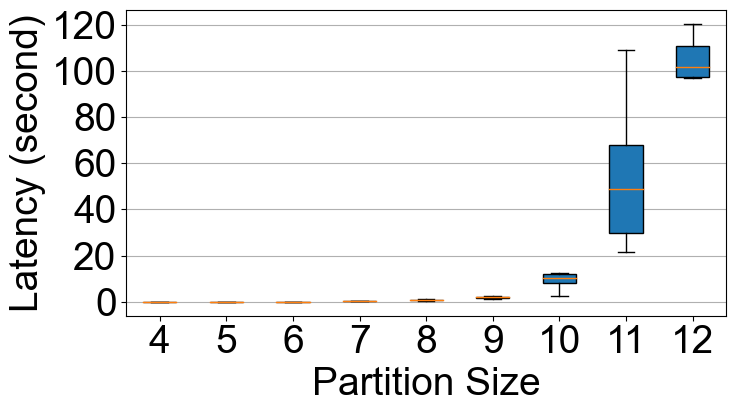

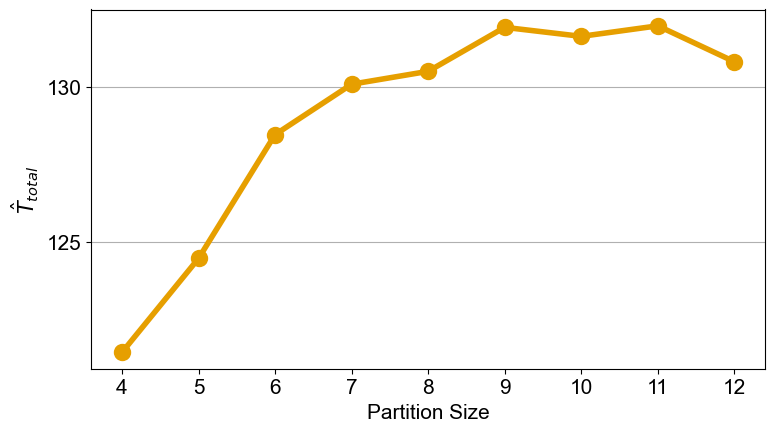

In [4]:
plot_latency_cluster_box()
plot_latency_performance_box()